# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

In [1]:
# Load modules.
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0).
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space.
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images.
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    #print(fname)
    # Read in a calibration image.
    img = mpimg.imread(fname)
    # Convert calibration image to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners for grayscale images.
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points.
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners.
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('Chessboard',img)
        cv2.waitKey(500)
        
'''
    # Save modified calibration images
    path = str(fname)
    filename = path.split('/')[-1]
    img_name = filename.split('.')[-2]
    new_path = './output_images/' + img_name
    mpimg.imsave(new_path, img)
'''

# Close all windows.
cv2.destroyAllWindows()

## Build an advanced lane line finding pipeline

### Load modules

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

### Helper functions

In [3]:
# Function that performs a camera calibration, image distortion correction and returns an undistorted image.
def cal_undistort(img, objpoints, imgpoints):
    # Calculate camera calibration:
    # camera matrix 'mtx'
    # distortion coefficients 'dist'
    # Position of camera in real world: rotation ('rvecs') and translation ('tvecs') vectors.
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort image.
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Function that computes the Sobel gradient in 'x' or 'y' direction, takes the absolute value and applies a threshold.
# sobel_kernel is an odd number >=3.
# thresh runs from 0 to 255.
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Convert image to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function and take the absolute value.
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer.
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold.
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result.
    return grad_binary

# Function that computes the magnitude of the Sobel gradients and applies a threshold.
# sobel_kernel is an odd number >=3.
# thresh runs from 0 to 255.
def mag_thresh(img, sobel_kernel, mag_thresh):
    # Convert to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients.
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude.
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit.
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise.
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image.
    return mag_binary

# Function that computes the direction of the Sobel gradients and applies a threshold.
# sobel_kernel is an odd number >=3.
# thresh runs from 0 to pi/2.
def dir_threshold(img, sobel_kernel, thresh):
    # Grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients.
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, apply a threshold, and create a binary image result.
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image.
    return dir_binary
                        
# Function that explores RGB colour space.
def rgb_threshold(img, thresh, channel):
    # Define channel:
    # R = 0, G = 1 & B = 2.
    colour = img[:,:,channel]
    # Create a binary mask where thresholds are met.
    binary = np.zeros_like(colour)
    binary[(colour > thresh[0]) & (colour <= thresh[1])] = 1
    # Return the binary image.
    return binary

# Function that explores HLS colour space.
def hls_threshold(img, thresh, channel):
    # Convert to HLS colour space.
    # H = 0, L = 1 & S = 2.
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    colour = hls[:,:,channel]
    # Create a binary mask where thresholds are met.
    binary = np.zeros_like(colour)
    binary[(colour > thresh[0]) & (colour <= thresh[1])] = 1
    # Return the binary image.
    return binary

# Function that performs a perspective transform of an image.
def warper(img, src, dst):
    # Get size of image.
    img_size = (img.shape[1], img.shape[0])
    # Compute the perspective transform.
    M = cv2.getPerspectiveTransform(src, dst)
    # Apply the perspective transform.
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    # Return the warped image.
    return warped

### Pipeline

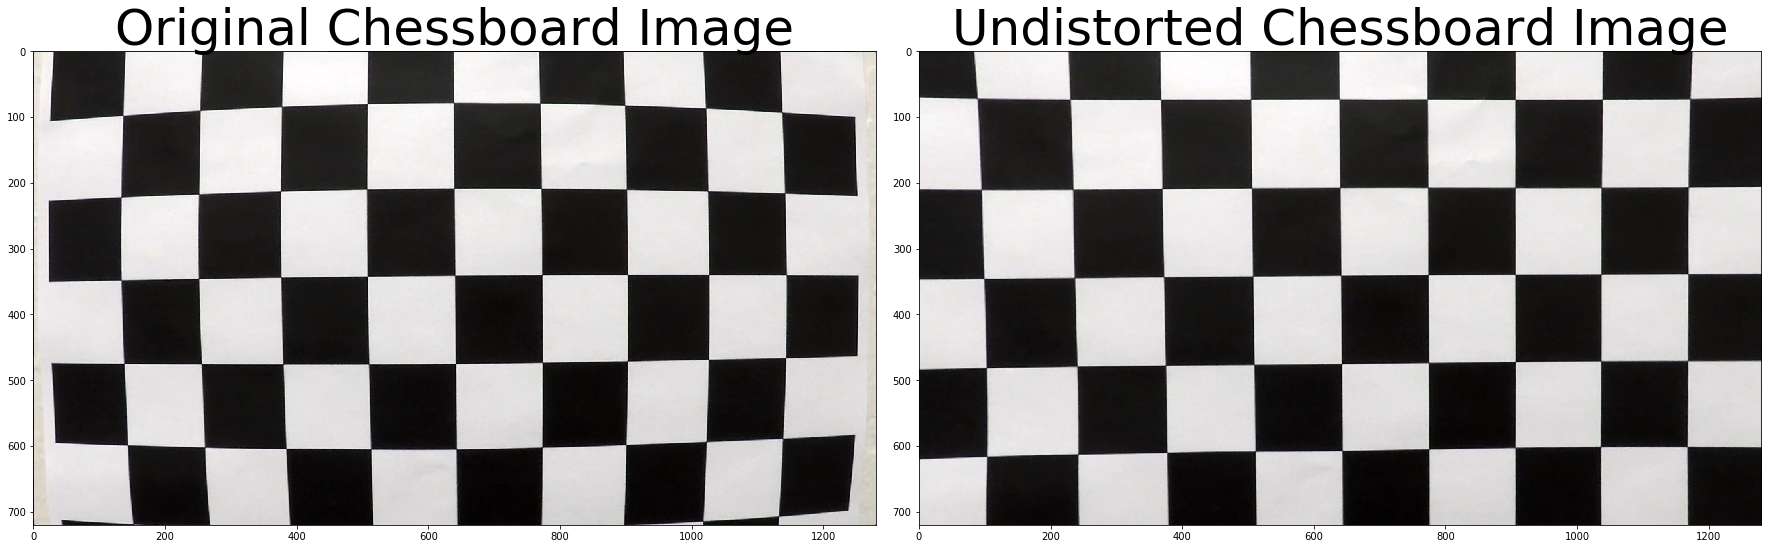

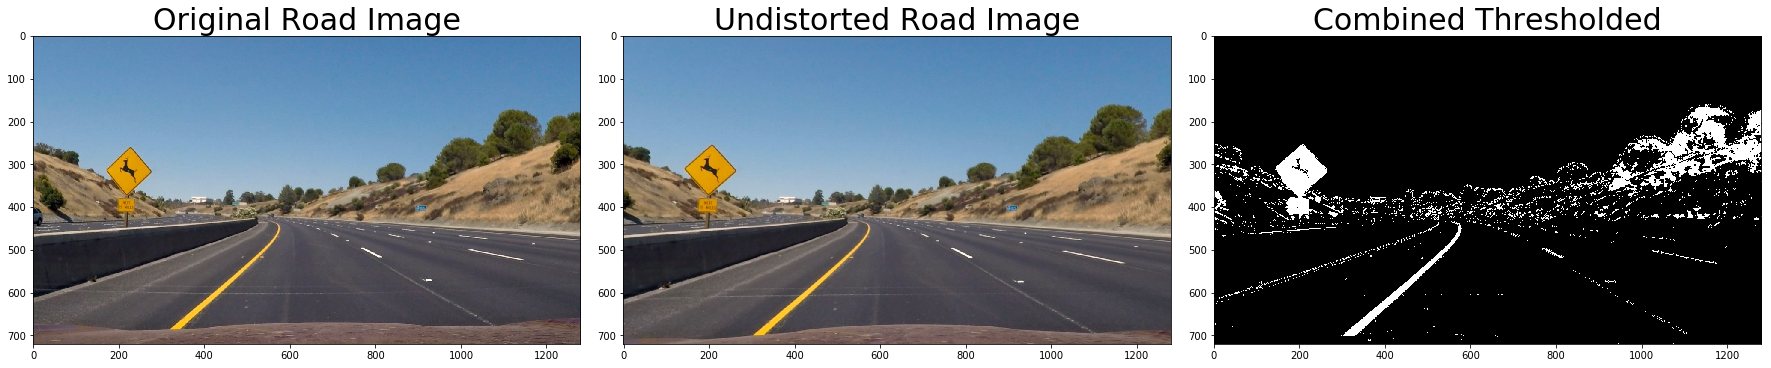

In [6]:
# Choose a Sobel kernel size.
ksize = 15 # Choose a larger odd number to smooth gradient measurements.

# Make a list of the road images.
images = glob.glob('./test_images/*.jpg')

# Step through all road images.
for fname in images:
    #print(fname)
    
    # Read in a road image.
    img = mpimg.imread(fname)
    
    # DISTORTION CORRECTION    
    # Undistort all road images and save them.
    # Undistort road image.
    undistorted = cal_undistort(img, objpoints, imgpoints)

    '''
    # Save undistorted road images.
    path = str(fname)
    filename = path.split('/')[-1]
    img_name = filename.split('.')[-2]
    new_path = './output_images/undistorted_' + img_name
    #print(new_path)
    mpimg.imsave(new_path, undistorted)
    '''
    
    # THRESHOLDS
    # Apply thresholding mask to all road images and save them.
    # Apply each of the thresholding functions.
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    #mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    r_channel = rgb_threshold(undistorted, thresh=(200,255), channel=0)
    g_channel = rgb_threshold(undistorted, thresh=(200,255), channel=1)
    h_channel = hls_threshold(undistorted, thresh=(15,100), channel=0)
    s_channel = hls_threshold(undistorted, thresh=(90,255), channel=2)

    # Combine thresholding functions appropriately.
    combined = np.zeros_like(s_channel)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((r_channel == 1) & (g_channel == 1))] = 1
    #combined[((h_channel == 1) & (s_channel == 1))] = 1
    #combined[((h_channel == 1) & (s_channel == 1)) | ((r_channel == 1) & (g_channel == 1)) | ((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((h_channel == 1) & (s_channel == 1)) | ((r_channel == 1) & (g_channel == 1))] = 1
    combined[((h_channel == 1) & (s_channel == 1)) | ((r_channel == 1) & (g_channel == 1)) | ((gradx == 1) & (grady == 1))] = 1
    #combined[((h_channel == 1) & (s_channel == 1)) | ((r_channel == 1) & (g_channel == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    '''
    # Save binary road images.
    path = str(fname)
    filename = path.split('/')[-1]
    img_name = filename.split('.')[-2]
    new_path = './output_images/binary_' + img_name
    mpimg.imsave(new_path, combined, cmap='gray')
    '''
    
    # PERSPECTIVE TRANSFORM
    # 
    
# Undistort, plot and save a chessboard image for reference.
# Read in a chessboard image.
img_chess = mpimg.imread('./camera_cal/calibration1.jpg')
# Undistort chessboard image.
undistorted_chess = cal_undistort(img_chess, objpoints, imgpoints)
# Plot undistorted chessboard image.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_chess)
ax1.set_title('Original Chessboard Image', fontsize=50)
ax2.imshow(undistorted_chess)
ax2.set_title('Undistorted Chessboard Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
'''
# Save undistorted road image.
path = './output_images/undistorted_chessboard'
mpimg.imsave(path, undistorted)
'''
   
# Plot example image of undistorted and binary road image.
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Road Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Road Image', fontsize=30)
ax3.imshow(combined, cmap='gray')
ax3.set_title('Combined Thresholded', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


---
## Appendi A: Perspective Transform

In [14]:
# Load modules.
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# Load road image with straight lane lines.
img_pt = mpimg.imread('./test_images/straight_lines1.jpg')

# Undistort and display the road image with straight lane lines.
undist_pt = cal_undistort(img_pt, objpoints, imgpoints)
plt.imshow(undist_pt)

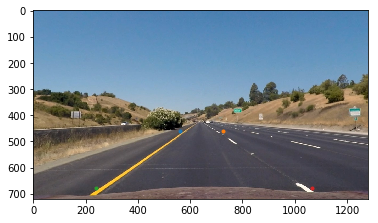

In [35]:
%matplotlib inline

# Plot undistorted road image (with straight lane lines) together with the source points.
plt.imshow(undist_pt)
plt.plot(560, 460, '.') # top left
plt.plot(725, 460, '.') # top right
plt.plot(240, 680, '.') # bottom left
plt.plot(1065, 680, '.') # bottom right

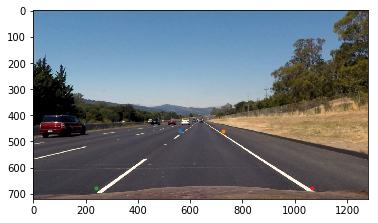

In [37]:
%matplotlib inline

# Test the source points on a second road image with straight lane lines.
# Load a second road image with straight lane lines and undistort it.
img_pt = mpimg.imread('./test_images/straight_lines2.jpg')
undist_pt = cal_undistort(img_pt, objpoints, imgpoints)

# Plot the second undistorted road image (with straight lane lines) together with the source points for reference.
plt.imshow(undist_pt)
plt.plot(560, 460, '.') # top left
plt.plot(725, 460, '.') # top right
plt.plot(240, 680, '.') # bottom left
plt.plot(1065, 680, '.') # bottom right